In [1]:
# Enable autoreload to auto-reload modules when edited
%reload_ext autoreload
%autoreload 2

# Standard libraries
import sys
import time
import calendar
import warnings
from datetime import datetime, timedelta, date
from pathlib import Path
import logging

# Data science and ML
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Machine learning
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from xgboost import XGBClassifier
import shap

# BigQuery
import pandas_gbq
from google.cloud import bigquery

# Serialization
import pickle
import cloudpickle

# Custom modules
import dataimp.data_preps
from dataimp import *

# Pandas display options for large DataFrames
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Suppress warnings
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)

# Initialize BigQuery client once
client = bigquery.Client()
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

from sklearn.utils import resample

## Prepare Data

1. Merge specified range of snapshots
2. Split into train and test data (StratifiedShuffleSplit)

In [2]:
import pandas as pd
from pathlib import Path

# Optionally, skip using raw_data_file_path since we won't save it
date_ranges = [
    'digigold_feature_2025-08-01',
    'digigold_feature_2025-05-01',
    'digigold_feature_2025-06-01'
]

data = pd.DataFrame()
summary_list = []

for date in date_ranges:
    file_path = f'Revisedsnapshots/{date}.csv'
    new_df = pd.read_csv(file_path)
    print(f"Loaded {file_path}, shape: {new_df.shape}")

    # Calculate conversion metrics
    total = len(new_df)
    conversions = new_df['on_us_target'].sum() 
    conv_rate = (conversions / total * 100) if total > 0 else 0

    summary_list.append({
        'snapshot': date,
        'total_records': total,
        'total_conversions': conversions,
        'conversion_rate_%': round(conv_rate, 2)
    })

    # Append data
    data = pd.concat([data, new_df], ignore_index=True)

# Show summary
summary_df = pd.DataFrame(summary_list)
print("\n📊 Conversion summary per snapshot:")
print(summary_df)

print(f"\nFinal combined shape: {data.shape}")

Loaded Revisedsnapshots/digigold_feature_2025-08-01.csv, shape: (6641693, 198)
Loaded Revisedsnapshots/digigold_feature_2025-05-01.csv, shape: (5528329, 198)
Loaded Revisedsnapshots/digigold_feature_2025-06-01.csv, shape: (5868816, 198)

📊 Conversion summary per snapshot:
                      snapshot  total_records  total_conversions  \
0  digigold_feature_2025-08-01        6641693               1830   
1  digigold_feature_2025-05-01        5528329               1624   
2  digigold_feature_2025-06-01        5868816               1367   

   conversion_rate_%  
0               0.03  
1               0.03  
2               0.02  

Final combined shape: (18038838, 198)


In [3]:
feature_less_impt = ['pl_enq_count_3m',
 'pl_enq_amt_3m',
 'pl_enq_count_6m',
 'pl_enq_amt_6m',
 'provident_fund_6m_12m_ratio',
 'provident_fund_3m_12m_ratio',
 'salary_12m',
 'salary_6m',
 'provident_fund_3m_6m_ratio',
 'salary_3m',
 'mutual_fund_3m_12m_ratio',
 'mutual_fund_6m_12m_ratio',
 'provident_fund_1m_3m_ratio',
 'mutual_fund_3m_6m_ratio',
 'cc_enq_count_3m',
 'cc_enq_count_6m',
 'cc_enq_amt_3m',
 'cc_enq_amt_6m',
 'mutual_fund_1m_3m_ratio',
 'salary_1m',
 'fixed_deposit_6m_12m_ratio',
 'fixed_deposit_3m_12m_ratio',
 'recurring_deposit_3m_12m_ratio',
 'recurring_deposit_6m_12m_ratio',
 'fixed_deposit_3m_6m_ratio',
 'bl_enq_count_6m',
 'bl_enq_amt_3m',
 'bl_enq_amt_6m',
 'bl_enq_count_3m',
 'hfl_enq_amt_6m',
 'hfl_enq_count_3m',
 'hfl_enq_amt_3m',
 'hfl_enq_count_6m',
 'fixed_deposit_1m_3m_ratio',
 'term_deposit_6m_12m_ratio',
 'term_deposit_3m_12m_ratio',
 'recurring_deposit_3m_6m_ratio',
 'trading_6m_12m_ratio',
 'trading_3m_12m_ratio',
 'term_deposit_3m_6m_ratio',
 'trading_3m_6m_ratio',
 'term_deposit_1m_3m_ratio',
 'trading_1m_3m_ratio',
 'recurring_deposit_1m_3m_ratio',
 'nps_6m_12m_ratio',
 'nps_3m_12m_ratio',
 'nps_3m_6m_ratio',
 'nps_1m_3m_ratio',
'fixed_deposit_1m_scaled',
 'recurring_deposit_1m_scaled',
 'term_deposit_1m_scaled',
 'provident_fund_1m_scaled',
 'nps_1m_scaled',
 'mutual_fund_1m_scaled',
 'trading_1m_scaled',
 'fixed_deposit_3m_scaled',
 'recurring_deposit_3m_scaled',
 'term_deposit_3m_scaled',
 'provident_fund_3m_scaled',
 'nps_3m_scaled',
 'mutual_fund_3m_scaled',
 'trading_3m_scaled',
 'fixed_deposit_6m_scaled',
 'recurring_deposit_6m_scaled',
 'term_deposit_6m_scaled',
 'provident_fund_6m_scaled',
 'nps_6m_scaled',
 'mutual_fund_6m_scaled',
 'trading_6m_scaled',
 'fixed_deposit_12m_scaled',
 'recurring_deposit_12m_scaled',
 'term_deposit_12m_scaled',
 'provident_fund_12m_scaled',
 'nps_12m_scaled',
 'mutual_fund_12m_scaled',
 'trading_12m_scaled']


data.drop(feature_less_impt,axis=1,inplace=True)

In [4]:
data.columns.to_list()

['mobilenumber',
 'customer_id',
 'createddate',
 'on_us_target',
 'total_investment_app',
 'transactions',
 'IsGymLover',
 'IsSingle',
 'IsParent',
 'insuranceservices',
 'PLApps',
 'DigiGoldApps',
 'UPIApps',
 'investmentsapps',
 'InsuranceApps',
 'HouseHoldSize',
 'IsTechie',
 'IsCarOwner',
 'IsTraveler',
 'IsUsingDigitalPayment',
 'fixed_deposit_1m',
 'fixed_deposit_3m',
 'fixed_deposit_6m',
 'fixed_deposit_12m',
 'recurring_deposit_1m',
 'recurring_deposit_3m',
 'recurring_deposit_6m',
 'recurring_deposit_12m',
 'term_deposit_1m',
 'term_deposit_3m',
 'term_deposit_6m',
 'term_deposit_12m',
 'provident_fund_1m',
 'provident_fund_3m',
 'provident_fund_6m',
 'provident_fund_12m',
 'nps_1m',
 'nps_3m',
 'nps_6m',
 'nps_12m',
 'mutual_fund_1m',
 'mutual_fund_3m',
 'mutual_fund_6m',
 'mutual_fund_12m',
 'trading_1m',
 'trading_3m',
 'trading_6m',
 'trading_12m',
 'amt_insurance_spend_1m',
 'amt_investment_spend_1m',
 'amt_medical_spend_1m',
 'amt_bills_utilities_spend_1m',
 'amt_shoppi

In [5]:
data.on_us_target.value_counts()

on_us_target
0    18034017
1        4821
Name: count, dtype: int64

In [6]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18038838 entries, 0 to 18038837
Columns: 122 entries, mobilenumber to EXPERIAN_Score_V3
dtypes: float64(101), int64(17), object(4)
memory usage: 19.7 GB


In [7]:
data.customer_id.nunique(),data.shape[0]

(6618243, 18038838)

## Event Rate

In [8]:
round(data['on_us_target'].sum() * 100/ data.shape[0], 2)

0.03

# selecting input and output

In [10]:
x = data.drop(columns=['on_us_target', 'customer_id', 'mobilenumber','createddate'])
y = data['on_us_target']

In [11]:
x.shape,y.shape

((18038838, 118), (18038838,))

# handling imbalance data

In [12]:
# Take all positives + sample negatives
pos = x[y==1]
neg = x[y==0]
pos.shape

(4821, 118)

In [13]:
# Sample negatives: 20x number of positives (tunable)
neg_sample = neg.sample(n=len(pos)*20, random_state=42)
neg_sample.shape

(96420, 118)

In [14]:
# Combine positives and sampled negatives
x_bal = pd.concat([pos, neg_sample])
x_bal.shape

(101241, 118)

In [15]:
y_bal = pd.concat([y[y==1], y[y==0].sample(n=len(pos)*20, random_state=42)])
y_bal.shape

(101241,)

In [16]:
from sklearn.utils import shuffle
#randomly shuffling the sample.
x_bal, y_bal = shuffle(x_bal, y_bal, random_state=42)

In [17]:
scale_pos_weight = (y_bal==0).sum() / (y_bal==1).sum()
scale_pos_weight

20.0

In [27]:
# Convert all object columns to category
for col in x_bal.select_dtypes(include='object').columns:
    x_bal[col] = x_bal[col].astype('category')

In [18]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score

In [19]:
def check_convergence(trials, patience=10, min_gain=0.001):
    """Stop if no significant gain in AUC over last `patience` iterations."""
    if len(trials.trials) < patience:
        return False

    aucs = [-trial['result']['loss'] for trial in trials.trials]
    recent = aucs[-patience:]
    if max(recent) - min(recent) < min_gain:
        return True
    return False


# doing tuning

In [24]:
def objective(space):
    clf = XGBClassifier(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        learning_rate=space['learning_rate'],
        gamma=space['gamma'],
        subsample=space['subsample'],
        colsample_bytree=space['colsample_bytree'],
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda'],
        min_child_weight=int(space['min_child_weight']),
        scale_pos_weight=len(neg_sample)/len(pos),
        enable_categorical=True,
        use_label_encoder=False,
        eval_metric='auc',
        n_jobs=-1,
        verbosity=0
    )
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc = cross_val_score(clf, x_bal, y_bal, cv=skf,
                          scoring=make_scorer(roc_auc_score)).mean()
    
    return {'loss': -auc, 'status': STATUS_OK}

In [25]:
#Define Search Space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 25),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'gamma': hp.uniform('gamma', 0, 5),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 5),
    'reg_lambda': hp.uniform('reg_lambda', 0, 5),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1) #Controls model complexity – avoids overfitting on noise
}


In [28]:
trials = Trials()
max_total_evals = 60 # Total maximum allowed trials (evaluations)
evals_step = 10        # How many new trials to add in each loop iteration
done = False

while not done and len(trials.trials) < max_total_evals:
    fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=len(trials.trials) + evals_step,
        trials=trials,
        rstate=np.random.default_rng(42)
    )
    
    done = check_convergence(trials, patience=10, min_gain=0.001)


  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]2025-10-06 18:14:18,448 - INFO - build_posterior_wrapper took 0.002346 seconds
2025-10-06 18:14:18,449 - INFO - TPE using 0 trials
 10%|█         | 1/10 [00:05<00:48,  5.40s/trial, best loss: -1.0]2025-10-06 18:14:23,852 - INFO - build_posterior_wrapper took 0.002472 seconds
2025-10-06 18:14:23,853 - INFO - TPE using 1/1 trials with best loss -1.000000
 20%|██        | 2/10 [00:08<00:33,  4.20s/trial, best loss: -1.0]2025-10-06 18:14:27,213 - INFO - build_posterior_wrapper took 0.002512 seconds
2025-10-06 18:14:27,214 - INFO - TPE using 2/2 trials with best loss -1.000000
 30%|███       | 3/10 [00:12<00:28,  4.00s/trial, best loss: -1.0]2025-10-06 18:14:30,974 - INFO - build_posterior_wrapper took 0.002457 seconds
2025-10-06 18:14:30,975 - INFO - TPE using 3/3 trials with best loss -1.000000
 40%|████      | 4/10 [00:37<01:12, 12.16s/trial, best loss: -1.0]2025-10-06 18:14:55,648 - INFO - build_posterior_wrapper took 0.002438 second

In [29]:
best_params = trials.best_trial['result']
best_hyperparams = trials.best_trial['misc']['vals']
print("\n✅ Best Hyperparameters:")
print({k: v[0] if isinstance(v, list) else v for k, v in best_hyperparams.items()})


✅ Best Hyperparameters:
{'colsample_bytree': 0.7420924529192455, 'gamma': 1.6199951785771693, 'learning_rate': 0.21751195314279886, 'max_depth': 4.0, 'min_child_weight': 8.0, 'n_estimators': 350.0, 'reg_alpha': 4.419633127363078, 'reg_lambda': 3.100594988383205, 'subsample': 0.9068277038201439}


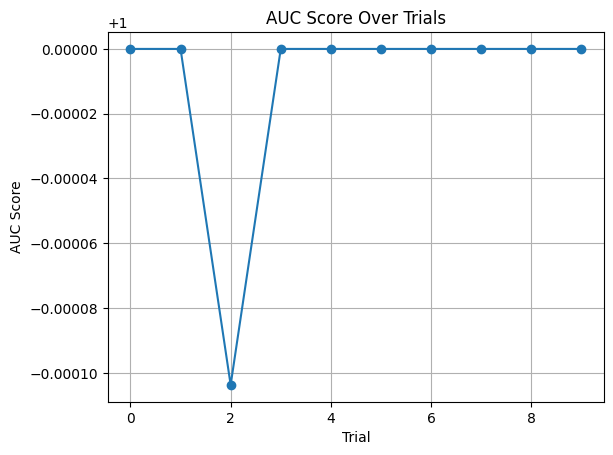

In [30]:
# ----- Plot AUC over Trials -----
aucs = [-t['result']['loss'] for t in trials.trials]
plt.plot(aucs, marker='o')
plt.xlabel("Trial")
plt.ylabel("AUC Score")
plt.title("AUC Score Over Trials")
plt.grid(True)
plt.show()